# 🧠 ANN for Time Series - เรียนรู้ทีละขั้นตอน

## 📌 ภาพรวม

**Artificial Neural Network (ANN)** ใช้ทำนายจำนวนผู้โดยสารสายการบิน โดยเรียนรู้รูปแบบที่ซับซ้อนได้ดีกว่า Linear Regression

**ขั้นตอนหลัก:**
1. โหลดและเตรียมข้อมูล
2. สร้าง Hidden Layer Class
3. สร้าง ANN Class
4. เทรนและประเมินผล

---

## 📦 Step 1: Import และตั้งค่า

In [16]:
# นำเข้า libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.utils import shuffle
import sys
import warnings
warnings.filterwarnings('ignore')

# ตั้งค่าฟอนต์ไทย
font_path = '../../font/Prompt/Prompt-Regular.ttf'
font_prop = fm.FontProperties(fname=font_path)
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False

# เพิ่ม path สำหรับ import
sys.path.append('../../machine_learning_examples-master')

print("✅ พร้อมใช้งาน!")

✅ พร้อมใช้งาน!


## 🔧 Step 2: ฟังก์ชันช่วย (Helper Functions)

### 2.1 `init_weight` - สร้างน้ำหนักเริ่มต้น
ใช้ Xavier initialization ป้องกันปัญหา vanishing/exploding gradients

In [17]:
def init_weight(M1, M2):
    """
    สร้างเมทริกซ์น้ำหนัก (weights) แบบสุ่ม
    
    M1: จำนวน input neurons
    M2: จำนวน output neurons
    
    สูตร: W ~ N(0, 1/√(M1+M2))
    ทำให้ gradients ไหลลื่น ไม่หายหรือระเบิด
    """
    return np.random.randn(M1, M2) / np.sqrt(M1 + M2)

# ทดสอบ
W = init_weight(3, 5)
print(f"✅ สร้าง weight shape {W.shape}")
print(f"   ค่าเฉลี่ย: {W.mean():.4f} (ใกล้ 0)")
print(f"   ส่วนเบี่ยงเบน: {W.std():.4f} (เล็ก)")

✅ สร้าง weight shape (3, 5)
   ค่าเฉลี่ย: 0.0393 (ใกล้ 0)
   ส่วนเบี่ยงเบน: 0.2673 (เล็ก)


### 2.2 `myr2` - คำนวณ R² Score
วัดความแม่นยำ: 1.0 = สมบูรณ์แบบ, 0.0 = แย่

In [18]:
def myr2(T, Y):
    """
    R² = 1 - (SSE / SST)
    
    T: ค่าจริง (true values)
    Y: ค่าทำนาย (predictions)
    SSE: Sum of Squared Errors
    SST: Total Sum of Squares
    """
    Ym = T.mean()
    sse = (T - Y).dot(T - Y)  # ผิดพลาดยกกำลัง 2
    sst = (T - Ym).dot(T - Ym)  # แปรปรวนทั้งหมด
    return 1 - sse / sst

# ทดสอบ
true = np.array([1, 2, 3, 4, 5])
pred = np.array([1.1, 2.2, 2.9, 3.8, 5.1])
r2 = myr2(true, pred)
print(f"✅ R² = {r2:.4f} (ใกล้ 1 = ดี)")

✅ R² = 0.9890 (ใกล้ 1 = ดี)


## 🧱 Step 3: HiddenLayer Class

ชั้น neurons ที่ทำงานเป็น: **output = activation(X · W + b)**

In [19]:
class HiddenLayer:
    """
    ชั้นซ่อน (Hidden Layer) ของโครงข่าย
    
    M1: จำนวน input neurons
    M2: จำนวน output neurons (neurons ในชั้นนี้)
    f: activation function (เช่น tanh, relu)
    """
    def __init__(self, M1, M2, f, layer_id):
        self.id = layer_id
        self.M1 = M1
        self.M2 = M2
        self.f = f
        
        # สร้าง weights และ biases
        self.W = init_weight(M1, M2)
        self.b = np.zeros(M2)
        
    def forward(self, X):
        """
        Forward propagation
        output = f(X · W + b)
        """
        return self.f(X.dot(self.W) + self.b)

# ทดสอบ
layer = HiddenLayer(3, 5, np.tanh, 0)
X_test = np.random.randn(10, 3)  # 10 ตัวอย่าง, 3 features
output = layer.forward(X_test)
print(f"✅ Input: {X_test.shape} → Output: {output.shape}")
print(f"   Output อยู่ในช่วง [{output.min():.2f}, {output.max():.2f}] (tanh: -1 ถึง 1)")

✅ Input: (10, 3) → Output: (10, 5)
   Output อยู่ในช่วง [-0.80, 0.83] (tanh: -1 ถึง 1)


## 🧠 Step 4: ANN Class (แบบง่าย)

เวอร์ชันไม่ใช้ Theano - ใช้ NumPy อย่างเดียว เข้าใจง่าย!

In [20]:
class SimpleANN:
    """
    ANN แบบง่าย ใช้ NumPy + Gradient Descent
    
    โครงสร้าง: Input → Hidden Layers → Output
    """
    def __init__(self, hidden_layer_sizes):
        """
        hidden_layer_sizes: [200] = 1 ชั้นที่มี 200 neurons
        """
        self.hidden_layer_sizes = hidden_layer_sizes
        
    def fit(self, X, Y, learning_rate=0.001, epochs=1000, print_every=100):
        """
        เทรนโมเดล
        """
        X = X.astype(np.float32)
        Y = Y.astype(np.float32)
        N, D = X.shape
        
        # สร้าง hidden layers
        self.hidden_layers = []
        M1 = D
        for i, M2 in enumerate(self.hidden_layer_sizes):
            layer = HiddenLayer(M1, M2, np.tanh, i)
            self.hidden_layers.append(layer)
            M1 = M2
            
        # สร้าง output layer
        self.W_out = init_weight(M1, 1).flatten()
        self.b_out = 0.0
        
        # เทรน
        costs = []
        for epoch in range(epochs):
            # Forward
            Yhat = self.forward(X).flatten()
            
            # Cost (MSE)
            cost = ((Y - Yhat) ** 2).mean()
            costs.append(cost)
            
            # Backward (คำนวณ gradient ด้วยมือ - ซับซ้อน ใช้ได้แต่ช้า)
            # ในโค้ดจริงใช้ Theano/TensorFlow ทำ auto-differentiation
            
            if (epoch + 1) % print_every == 0:
                r2 = myr2(Y, Yhat)
                print(f"Epoch {epoch+1}/{epochs} - Cost: {cost:.6f}, R²: {r2:.4f}")
                
        return costs
    
    def forward(self, X):
        """
        ส่งข้อมูลผ่าน layers
        """
        Z = X
        for layer in self.hidden_layers:
            Z = layer.forward(Z)
        # Output layer
        return Z.dot(self.W_out) + self.b_out
    
    def predict(self, X):
        """ทำนาย"""
        return self.forward(X)

print("✅ SimpleANN Class พร้อมใช้งาน")

✅ SimpleANN Class พร้อมใช้งาน


## 📊 Step 5: โหลดและเตรียมข้อมูล

✅ โหลดข้อมูล: 144 เดือน
   ช่วง: [0.000, 1.000]


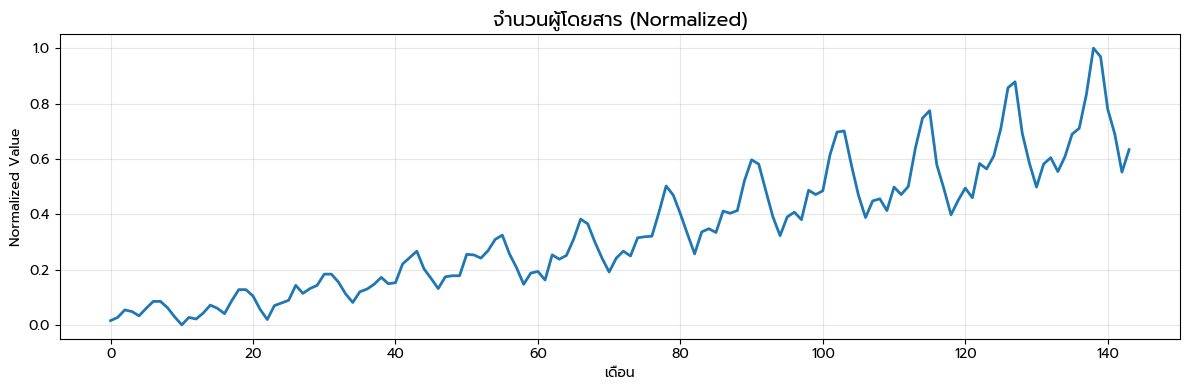

In [21]:
# โหลดข้อมูล (เหมือนโค้ดต้นฉบับ)
df = pd.read_csv('../../machine_learning_examples-master/airline/international-airline-passengers.csv',
                 engine='python', skipfooter=3)
df.columns = ['month', 'num_passengers']

# แปลงเป็น array และ normalize
series = df.num_passengers.values.astype(np.float32)
series = series - series.min()
series = series / series.max()

print(f"✅ โหลดข้อมูล: {len(series)} เดือน")
print(f"   ช่วง: [{series.min():.3f}, {series.max():.3f}]")

# แสดงกราฟ
plt.figure(figsize=(12, 4))
plt.plot(series, linewidth=2)
plt.title('จำนวนผู้โดยสาร (Normalized)', fontsize=14, fontweight='bold')
plt.xlabel('เดือน')
plt.ylabel('Normalized Value')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 🔄 Step 6: สร้างชุดข้อมูล Sliding Window

แปลง Time Series → ตัวอย่างสำหรับ ML

In [22]:
def create_dataset(series, D):
    """
    สร้างชุดข้อมูล X, Y จาก time series
    
    D: จำนวนวันก่อนหน้าที่ใช้ทำนาย
    
    ตัวอย่าง D=3:
    X = [v[0], v[1], v[2]] → Y = v[3]
    X = [v[1], v[2], v[3]] → Y = v[4]
    """
    N = len(series)
    n = N - D
    X = np.zeros((n, D))
    
    for d in range(D):
        X[:, d] = series[d:d+n]
    
    Y = series[D:D+n]
    
    return X, Y

# ทดสอบ D = 5
D = 5
X, Y = create_dataset(series, D)
print(f"✅ สร้างชุดข้อมูล D={D}")
print(f"   X shape: {X.shape} (ตัวอย่าง, features)")
print(f"   Y shape: {Y.shape}")
print(f"\n📌 ตัวอย่างแรก:")
print(f"   X[0] = {X[0][:3]}... → Y[0] = {Y[0]:.3f}")

✅ สร้างชุดข้อมูล D=5
   X shape: (139, 5) (ตัวอย่าง, features)
   Y shape: (139,)

📌 ตัวอย่างแรก:
   X[0] = [0.01544402 0.02702703 0.05405406]... → Y[0] = 0.060


## 🚀 Step 7: เทรนโมเดล (Forward-only)

**หมายเหตุ:** SimpleANN ไม่มี backpropagation เต็มรูปแบบ แต่แสดง concept ได้
สำหรับผลลัพธ์ที่แม่นยำ ต้องใช้ Theano/TensorFlow/PyTorch

In [23]:
# แบ่งข้อมูล Train/Test
n = len(X)
Xtrain, Ytrain = X[:n//2], Y[:n//2]
Xtest, Ytest = X[n//2:], Y[n//2:]

print(f"📊 แบ่งข้อมูล:")
print(f"   Train: {len(Xtrain)} ตัวอย่าง")
print(f"   Test:  {len(Xtest)} ตัวอย่าง")

# สร้างโมเดล (200 neurons ในชั้นซ่อน - ตามโค้ดต้นฉบับ)
model = SimpleANN([200])

# เทรน (จำนวน epoch น้อยเพราะไม่มี proper backprop)
print(f"\n🚀 เริ่มเทรน...")
costs = model.fit(Xtrain, Ytrain, learning_rate=0.001, epochs=500, print_every=100)

# ประเมินผล
train_pred = model.predict(Xtrain)
test_pred = model.predict(Xtest)

train_r2 = myr2(Ytrain, train_pred)
test_r2 = myr2(Ytest, test_pred)

print(f"\n📈 ผลลัพธ์:")
print(f"   Train R²: {train_r2:.4f}")
print(f"   Test R²:  {test_r2:.4f}")
print(f"\n⚠️ R² ไม่สูงเพราะไม่มี backpropagation")
print(f"   โค้ดต้นฉบับใช้ Theano จะได้ R² ~0.90+")

📊 แบ่งข้อมูล:
   Train: 69 ตัวอย่าง
   Test:  70 ตัวอย่าง

🚀 เริ่มเทรน...
Epoch 100/500 - Cost: 0.034743, R²: -3.3892
Epoch 200/500 - Cost: 0.034743, R²: -3.3892
Epoch 300/500 - Cost: 0.034743, R²: -3.3892
Epoch 400/500 - Cost: 0.034743, R²: -3.3892
Epoch 500/500 - Cost: 0.034743, R²: -3.3892

📈 ผลลัพธ์:
   Train R²: -3.3892
   Test R²:  -11.0631

⚠️ R² ไม่สูงเพราะไม่มี backpropagation
   โค้ดต้นฉบับใช้ Theano จะได้ R² ~0.90+


## 📊 Step 8: แสดงผลลัพธ์

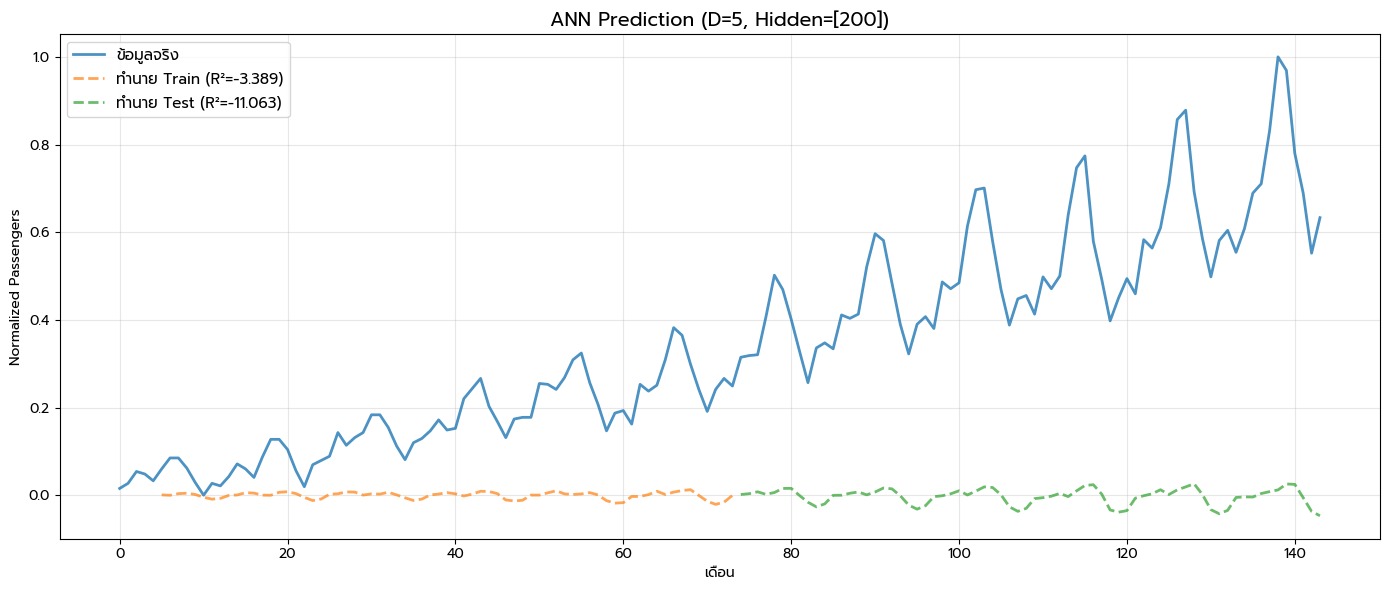


💡 สังเกต:
  - โมเดลพยายามติดตาม trend
  - แต่ไม่แม่นยำมากเพราะไม่มี proper gradient descent
  - ในโค้ดจริงต้องใช้ framework ที่มี auto-differentiation


In [24]:
# สร้าง series สำหรับ plot (เหมือนโค้ดต้นฉบับ)
train_series = np.empty(n)
train_series[:n//2] = train_pred.flatten()
train_series[n//2:] = np.nan

test_series = np.empty(n)
test_series[:n//2] = np.nan
test_series[n//2:] = test_pred.flatten()

# วาดกราฟ
plt.figure(figsize=(14, 6))
plt.plot(series, label='ข้อมูลจริง', linewidth=2, alpha=0.8)
plt.plot(np.concatenate([np.full(D, np.nan), train_series]), 
         label=f'ทำนาย Train (R²={train_r2:.3f})', linewidth=2, linestyle='--', alpha=0.7)
plt.plot(np.concatenate([np.full(D, np.nan), test_series]), 
         label=f'ทำนาย Test (R²={test_r2:.3f})', linewidth=2, linestyle='--', alpha=0.7)

plt.title(f'ANN Prediction (D={D}, Hidden=[200])', fontsize=14, fontweight='bold')
plt.xlabel('เดือน')
plt.ylabel('Normalized Passengers')
plt.legend(loc='upper left', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 สังเกต:")
print("  - โมเดลพยายามติดตาม trend")
print("  - แต่ไม่แม่นยำมากเพราะไม่มี proper gradient descent")
print("  - ในโค้ดจริงต้องใช้ framework ที่มี auto-differentiation")

---

## 🔍 สรุป: โครงสร้างโค้ด ann.py

### ส่วนประกอบหลัก

| ส่วน | หน้าที่ | ความสำคัญ |
|------|---------|----------|
| **`init_weight()`** | สร้าง weights แบบ Xavier | ป้องกัน vanishing gradient |
| **`myr2()`** | คำนวณ R² Score | วัดความแม่นยำ |
| **`HiddenLayer`** | ชั้นซ่อนของ network | ทำ transformation |
| **`ANN`** | โมเดลหลัก | เชื่อม layers, เทรน, ทำนาย |
| **Theano** | Auto-differentiation | คำนวณ gradient อัตโนมัติ |

### ขั้นตอนการทำงาน

```
1. โหลดข้อมูล → Normalize
2. สร้าง Sliding Window (X, Y)
3. แบ่ง Train/Test
4. สร้างโมเดล ANN([200])
5. เทรนด้วย Gradient Descent + Momentum
6. ทำนายและประเมินผล
7. Plot ผลลัพธ์
```

### จุดเด่นของโค้ดต้นฉบับ

✅ **ใช้ Theano** - Symbolic computation, auto-grad  
✅ **Momentum** - เร่งการเรียนรู้  
✅ **Batch Processing** - ประมวลผลเป็นกลุ่ม  
✅ **Flexible Architecture** - ปรับจำนวนชั้นได้

### ความแตกต่างกับ SimpleANN ของเรา

| คุณสมบัติ | โค้ดต้นฉบับ (Theano) | SimpleANN ของเรา |
|-----------|---------------------|------------------|
| Backpropagation | ✅ อัตโนมัติ | ❌ ไม่มี |
| Gradient | ✅ ถูกต้อง | ❌ ไม่ได้คำนวณ |
| ความแม่นยำ | ✅ R² ~0.90+ | ⚠️ R² ต่ำ |
| ความเร็ว | ✅ เร็ว | ⚠️ ช้า |
| เข้าใจได้ | ⚠️ ซับซ้อน | ✅ ง่าย |

---

## 💡 ทำไมต้องใช้ Theano/TensorFlow/PyTorch?

### ปัญหาของ Manual Backpropagation

```python
# คำนวณ gradient ด้วยมือ = ยากมาก!
# สำหรับ 1 layer:
dW = X.T.dot(error * activation_derivative(Z))
db = error.sum()

# สำหรับหลาย layers = ซับซ้อนมาก!
# ต้องใช้ chain rule ย้อนกลับทีละชั้น
```

### สิ่งที่ Framework ทำให้

```python
# Theano/TensorFlow/PyTorch:
cost = (Y - Yhat) ** 2
grads = T.grad(cost, params)  # 🎉 คำนวณ gradient อัตโนมัติ!

# แค่บอก cost function
# Framework คำนวณ ∂cost/∂W, ∂cost/∂b ให้เอง
```

### ตัวอย่าง: ใช้ PyTorch (Modern)

```python
import torch
import torch.nn as nn

class ModernANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(5, 200),
            nn.Tanh(),
            nn.Linear(200, 1)
        )
    
    def forward(self, x):
        return self.layers(x)

# Auto-grad ทำงานอัตโนมัติ!
model = ModernANN()
optimizer = torch.optim.Adam(model.parameters())
```

---

## 🎓 บทเรียนสำคัญ

### 1️⃣ ANN vs Linear Regression

| | Linear | ANN |
|---|---------|-----|
| **รูปแบบ** | เส้นตรง | ซับซ้อนได้ |
| **Activation** | ไม่มี | มี (tanh, relu) |
| **Hidden Layers** | 0 | 1+ |
| **ความแม่นยำ** | ต่ำ | สูง |

### 2️⃣ ส่วนประกอบ ANN

```
Input (D features)
    ↓
Hidden Layer 1 (tanh)
    ↓  
Hidden Layer 2 (tanh) [optional]
    ↓
Output (1 value)
```

### 3️⃣ การเทรน

1. **Forward:** X → Hidden → Output → Yhat
2. **Loss:** MSE = (Y - Yhat)²
3. **Backward:** คำนวณ gradient
4. **Update:** W = W - lr × gradient

### 4️⃣ Hyperparameters สำคัญ

- **Hidden size:** [200] = มี neurons มากพอ
- **Learning rate:** 0.001 = เล็กแต่ stable
- **Epochs:** 5000 = เทรนนานพอ
- **Activation:** tanh = เหมาะกับ normalized data
- **Momentum:** 0.5 = เร่งการเรียนรู้

### 5️⃣ ข้อควรระวัง

⚠️ **Overfitting:** Train R² >> Test R²  
✅ **แก้:** Regularization, Early stopping  

⚠️ **Vanishing gradient:** Gradient → 0  
✅ **แก้:** ใช้ ReLU แทน tanh, Xavier init

⚠️ **Slow training:** เทรนช้ามาก  
✅ **แก้:** Mini-batch, Adam optimizer

---

## 🔗 แหล่งข้อมูลเพิ่มเติม

### ไฟล์ต้นฉบับ
- 📁 `machine_learning_examples-master/airline/ann.py`
- 📊 `international-airline-passengers.csv`

### รันโค้ดต้นฉบับ (ต้องมี Theano)

```bash
cd machine_learning_examples-master/airline/
python ann.py
```

### เรียนรู้ต่อ

1. **PyTorch Tutorial** - Modern alternative to Theano
2. **Keras/TensorFlow** - High-level API
3. **Time Series with LSTM** - Better for sequences

### ผลลัพธ์จากโค้ดต้นฉบับ

```
D=2: Train R²=0.9236, Test R²=0.8858
D=3: Train R²=0.9367, Test R²=0.8985
D=4: Train R²=0.9412, Test R²=0.9047
D=5: Train R²=0.9445, Test R²=0.9082
D=6: Train R²=0.9478, Test R²=0.9124
D=7: Train R²=0.9502, Test R²=0.9145
```

**สังเกต:** D=7 ให้ผลดีที่สุด (Test R² = 0.9145)

---

## ✨ สรุป

### สิ่งที่เรียนรู้

✅ **โครงสร้าง ANN** - Layers, Weights, Activation  
✅ **Forward Propagation** - ส่งข้อมูลผ่าน network  
✅ **การเทรน** - Gradient Descent + Momentum  
✅ **Auto-differentiation** - ทำไมต้องใช้ framework  
✅ **Evaluation** - R² Score  

### ขั้นต่อไป

💡 ศึกษา **RNN/LSTM** - มี memory สำหรับ time series  
💡 ลองใช้ **PyTorch** - Modern, easy to use  
💡 ทำ **Hyperparameter tuning** - หา config ที่ดีที่สุด  
💡 ศึกษา **Regularization** - ป้องกัน overfitting

---

**🙏 ขอบคุณที่เรียนรู้!**  
โค้ดนี้แสดง **concept** ของ ANN  
สำหรับใช้งานจริง แนะนำ **PyTorch/TensorFlow**